## Practica :
Generar un modelo que me permita simular el uso de recursos de los hospitales por cada una de las provincias, para ello obtener la informacion revisada en la practica de investigacion y tomar como ejemplo la practica de simulacion de atencion de paciente del COVID revisada en clase. Lo que se busca es poder generar graficos de uso de recursos:

- Costos (Generar un aproximacion de cuanto se invierte para atender a un paciente con COVID)
- Personal (Aproximacion del uso del personal por paciente, o el hospital)
- Camas
- Equipos/Insumos medicos (Obtener una aproximacion del uso de equipos medicos)
- Pacientes (Informacion obtenida desde el ministerio de salud - validar con el porcentual del tipo de paciente [ninio 10%, adulto 30%, riesgo 60%]) - Hospitalizacion 80%, Otros 20%


Para ello deberan generar un modelo lo mas cercano a la realidad, y con ayuda de la estadistica descriptiva ajustar los valores. Es importante tener como datos de entrada el dia y el numero de pacientes.

Finalmente validar el modelo con lo la realidad del pais (Investigar en  base al tema el uso de los recursos publicos )


### (Azuay): 3

**Costo pacientes bajo riesgo::** 3.500

**Costo pacientes alto riesgo:** 5.700

**Personal por paciente:** 3

**Camas:** 563

**Respiradores:** 15

**UCI:** 5

**CASOS ACTUALES:** 671

**Acceso a la UCI:** 14% pacientes


In [1]:
import pandas as pd
import numpy as np

#Tasa de Crecimento en Azuay
url = 'Casos covid por provincias.xlsx'
df = pd.read_excel(url)
df = df.replace(np.nan, 0)
df=df[df['Provincia']=="Azuay"]
filtro = df.iloc[0].loc['19/3/2020':]
media = filtro.mean()
print(media)

115.28571428571429


In [2]:
import simpy
import random
import matplotlib.pyplot as pp
import numpy as np

%matplotlib inline

#PARAMETROS
HOSPITALES = 3
CAMAS = 563
RESPIRADORES=5
UCI=8
PERSONAL=278

COSTOB=3500
PRECIO_BAJO=int(COSTOB/15) 

PRECIOA=6700
PRECIOAIDA=int(PRECIOA/21)


INFECTADOS= 671
TASA_CRECIMIENTO = 48
DIAS_INTERNADO = 10
DIAS_SIMULACION = 25

costoTotal=[]
personalTotal={}
camasTotal={}
respiradoresTotal={}
UCITotal={}
ninios={}
adultos={}
atendidos={}
riesgo={}


persona_recuperadas={}
persona_fallecidas={}


class Hospital(object):

    def __init__(self, env,num_cama,name,num_personal,num_uci, num_respiradores):
            self.env = env
            self.num_cama = num_cama
            self.num_personal = num_personal
            self.num_uci=num_uci
            self.num_respiradores=num_respiradores
            self.camas = simpy.Resource(env, num_cama)
            self.personal = simpy.Resource(env, num_personal)
            self.uci = simpy.Resource(env, num_uci)
            self.respiradores = simpy.Resource(env, num_respiradores)
            self.name = name
        
    def ingreso_hospital(self, paciente):
        yield self.env.timeout(random.randint(DIAS_INTERNADO-5, DIAS_INTERNADO+5))
        print("Paciente Nº", paciente, "se le de de alta en el dia ", int(self.env.now))
        
    
        
    def cuidado_intensivo(self, paciente):
        yield self.env.timeout(random.randint(DIAS_INTERNADO-3, DIAS_INTERNADO+11))
        print("Paciente Nº", paciente, "deja ciudados intensivos ", int(self.env.now))
    
    def asignacion_respiradores(self, paciente):
        yield self.env.timeout(random.randint(DIAS_INTERNADO-3, DIAS_INTERNADO+11))
        print("Paciente Nº", paciente, "le quitan respirador ", int(self.env.now),'por fallecer.')
        
    
def llegada_paciente(env, hospital, paciente):
    arrive = env.now
    estado = random.randint(1,100)
    if (estado < 80) :
        tipo = random.randint(1,100)
        if (tipo < 10) :
            ninios[env.now] = ninios[env.now] + 1 if env.now in ninios else 1        
        elif(tipo < 30 and tipo>10) :
            adultos[env.now] = adultos[env.now] + 1 if env.now in adultos else 1 
        elif (tipo > 60) :
            riesgo[env.now] = riesgo[env.now] + 1 if env.now in riesgo else 1 

        with hospital.camas.request() as cama:
            llegadaC = env.now
            dias_esperando = random.randint(0,1) #Numero de dias maximo que puede esperar sin ser asignado a una cama dentro del hospital
            requerimientoC = yield cama | env.timeout(dias_esperando) #Asignar un tiempo de espera
            wait = env.now - llegadaC
            if cama in requerimientoC:
                print("Paciente Nº", paciente, " se le asigna una cama ")
                yield env.process(hospital.ingreso_hospital(paciente))
                estado = random.randint(1,100)
                camasTotal[env.now] = camasTotal[env.now] + 1 if env.now in camasTotal else 1 
                atendidos[env.now] = atendidos[env.now]+ 1 if env.now in atendidos else 1

                if (estado < 8) :
                    persona_fallecidas[env.now] = persona_fallecidas[env.now] + 1 if env.now in persona_fallecidas else  1
                else:
                    persona_recuperadas[env.now] = persona_recuperadas[env.now] + 1 if env.now in persona_recuperadas else 1       

           
                with hospital.personal.request() as personal:
                    llegadaP = env.now
                    dias_esperando = random.randint(0,1) #Numero de dias maximo que puede esperar sin ser asignado a una cama dentro del hospital
                    requerimientoP = yield personal | env.timeout(dias_esperando) #Asignar un tiempo de espera
                    waitP = env.now - llegadaP
                    if personal in requerimientoP:
                        print("Paciente Nº", paciente, " tiene personal medido disponible")
                        personalTotal[env.now] =  personalTotal[env.now] + 1 if env.now in  personalTotal else 1 
                        
            
                    acceso = random.randint(1,100)
                    if(acceso<28):
                        
                        with hospital.uci.request() as uci:
                            llegadaU = env.now
                            dias_esperando = random.randint(9,15) #Numero de dias maximo que puede esperar sin ser asignado a una cama dentro del hospital
                            requerimientoU = yield uci | env.timeout(dias_esperando) #Asignar un tiempo de espera
                            waitU = env.now - llegadaU
                            if uci in requerimientoU:
                                print("Paciente Nº", paciente, " pasa a la sala de ciudados intensivos ")
                                UCITotal[env.now] = UCITotal[env.now] + 1 if env.now in UCITotal else 1        
                                yield env.process(hospital.cuidado_intensivo(paciente))
                                estado = random.randint(1,100)
                                if (estado < 8) :
                                    persona_fallecidas[env.now] = persona_fallecidas[env.now] + 1 if env.now in persona_fallecidas else  1
                                else:
                                    persona_recuperadas[env.now] = persona_recuperadas[env.now] + 1 if env.now in persona_recuperadas else 1
                            
                                requiere = random.randint(1,100)
                                if(requiere<95):
                                    with hospital.respiradores.request() as respiradores:
                                        llegadaR = env.now
                                        requerimientoR = yield respiradores | env.timeout(0) #Asignar un tiempo de espera
                                        waitR = env.now - llegadaR
                                        if respiradores in requerimientoR:
                                            print("Paciente Nº", paciente, "se le asigna un respirador ")
                                            respiradoresTotal[env.now] = respiradoresTotal[env.now] + 1 if env.now in  respiradoresTotal else 1
                                            yield env.process(hospital.asignacion_respiradores(paciente))
                                            estado = random.randint(1,100)
                                            if (estado < 8) :
                                                persona_fallecidas[env.now] = persona_fallecidas[env.now] + 1 if env.now in persona_fallecidas else  1
                                            else:
                                                persona_recuperadas[env.now] = persona_recuperadas[env.now] + 1 if env.now in persona_recuperadas else 1
                                        else:
                                            print("Paciente Nº" , paciente," espero ", waitR , " días y fallece por falta de acceso a la sala UCI")
                                            persona_fallecidas[env.now] = persona_fallecidas[env.now] + 1 if env.now in persona_fallecidas else  1
                                    
                            else:
                                print("Paciente Nº" , paciente," espero ", waitU , " días y fallece por falta de acceso a la UCI")
                                persona_fallecidas[env.now] = persona_fallecidas[env.now] + 1 if env.now in persona_fallecidas else  1
                        
                    else:
                        print("El Paciente Nº" , paciente," espero ", waitP , " y se recuperó.")
            else:
                print("Paciente Nº" , paciente," espero ", wait , " días y fallece por falta de camas")
                persona_fallecidas[env.now] = persona_fallecidas[env.now] + 1 if env.now in persona_fallecidas else  1


def ejecutar(env, tasa_crecimiento, infectados):
    hospital = Hospital(env, CAMAS, "",PERSONAL,UCI,RESPIRADORES)
    for i in range(infectados):
        asignar_hospital(env, hospital, i)
    paciente = infectados
    while True:
        yield env.timeout(1)
        for i in range(tasa_crecimiento):
            paciente += 1
            asignar_hospital(env, hospital, paciente)
                
def asignar_hospital(env, hospital, paciente):
    hosp_esc = 1
    if (hosp_esc == 1):
        print("Llega paciente Nº: ", paciente, " en tiempo ", env.now)
        env.process(llegada_paciente(env, hospital, paciente))

print("Simulacion COVID-19")
env=simpy.Environment()
env.process(ejecutar(env,TASA_CRECIMIENTO,INFECTADOS))
env.run(until=DIAS_SIMULACION)


Simulacion COVID-19
Llega paciente Nº:  0  en tiempo  0
Llega paciente Nº:  1  en tiempo  0
Llega paciente Nº:  2  en tiempo  0
Llega paciente Nº:  3  en tiempo  0
Llega paciente Nº:  4  en tiempo  0
Llega paciente Nº:  5  en tiempo  0
Llega paciente Nº:  6  en tiempo  0
Llega paciente Nº:  7  en tiempo  0
Llega paciente Nº:  8  en tiempo  0
Llega paciente Nº:  9  en tiempo  0
Llega paciente Nº:  10  en tiempo  0
Llega paciente Nº:  11  en tiempo  0
Llega paciente Nº:  12  en tiempo  0
Llega paciente Nº:  13  en tiempo  0
Llega paciente Nº:  14  en tiempo  0
Llega paciente Nº:  15  en tiempo  0
Llega paciente Nº:  16  en tiempo  0
Llega paciente Nº:  17  en tiempo  0
Llega paciente Nº:  18  en tiempo  0
Llega paciente Nº:  19  en tiempo  0
Llega paciente Nº:  20  en tiempo  0
Llega paciente Nº:  21  en tiempo  0
Llega paciente Nº:  22  en tiempo  0
Llega paciente Nº:  23  en tiempo  0
Llega paciente Nº:  24  en tiempo  0
Llega paciente Nº:  25  en tiempo  0
Llega paciente Nº:  26  en t

Llega paciente Nº:  619  en tiempo  0
Llega paciente Nº:  620  en tiempo  0
Llega paciente Nº:  621  en tiempo  0
Llega paciente Nº:  622  en tiempo  0
Llega paciente Nº:  623  en tiempo  0
Llega paciente Nº:  624  en tiempo  0
Llega paciente Nº:  625  en tiempo  0
Llega paciente Nº:  626  en tiempo  0
Llega paciente Nº:  627  en tiempo  0
Llega paciente Nº:  628  en tiempo  0
Llega paciente Nº:  629  en tiempo  0
Llega paciente Nº:  630  en tiempo  0
Llega paciente Nº:  631  en tiempo  0
Llega paciente Nº:  632  en tiempo  0
Llega paciente Nº:  633  en tiempo  0
Llega paciente Nº:  634  en tiempo  0
Llega paciente Nº:  635  en tiempo  0
Llega paciente Nº:  636  en tiempo  0
Llega paciente Nº:  637  en tiempo  0
Llega paciente Nº:  638  en tiempo  0
Llega paciente Nº:  639  en tiempo  0
Llega paciente Nº:  640  en tiempo  0
Llega paciente Nº:  641  en tiempo  0
Llega paciente Nº:  642  en tiempo  0
Llega paciente Nº:  643  en tiempo  0
Llega paciente Nº:  644  en tiempo  0
Llega pacien

Paciente Nº 444  se le asigna una cama 
Paciente Nº 445  se le asigna una cama 
Paciente Nº 446  se le asigna una cama 
Paciente Nº 448  se le asigna una cama 
Paciente Nº 451  se le asigna una cama 
Paciente Nº 453  se le asigna una cama 
Paciente Nº 454  se le asigna una cama 
Paciente Nº 456  se le asigna una cama 
Paciente Nº 457  se le asigna una cama 
Paciente Nº 458  se le asigna una cama 
Paciente Nº 459  se le asigna una cama 
Paciente Nº 463  se le asigna una cama 
Paciente Nº 465  se le asigna una cama 
Paciente Nº 466  se le asigna una cama 
Paciente Nº 467  se le asigna una cama 
Paciente Nº 468  se le asigna una cama 
Paciente Nº 471  se le asigna una cama 
Paciente Nº 472  se le asigna una cama 
Paciente Nº 474  se le asigna una cama 
Paciente Nº 475  se le asigna una cama 
Paciente Nº 476  se le asigna una cama 
Paciente Nº 477  se le asigna una cama 
Paciente Nº 478  se le asigna una cama 
Paciente Nº 479  se le asigna una cama 
Paciente Nº 480  se le asigna una cama 


Paciente Nº 576 se le de de alta en el dia  5
Paciente Nº 577 se le de de alta en el dia  5
Paciente Nº 590 se le de de alta en el dia  5
Paciente Nº 594 se le de de alta en el dia  5
Paciente Nº 598 se le de de alta en el dia  5
Paciente Nº 600 se le de de alta en el dia  5
Paciente Nº 615 se le de de alta en el dia  5
Paciente Nº 640 se le de de alta en el dia  5
Paciente Nº 660 se le de de alta en el dia  5
Llega paciente Nº:  864  en tiempo  5
Llega paciente Nº:  865  en tiempo  5
Llega paciente Nº:  866  en tiempo  5
Llega paciente Nº:  867  en tiempo  5
Llega paciente Nº:  868  en tiempo  5
Llega paciente Nº:  869  en tiempo  5
Llega paciente Nº:  870  en tiempo  5
Llega paciente Nº:  871  en tiempo  5
Llega paciente Nº:  872  en tiempo  5
Llega paciente Nº:  873  en tiempo  5
Llega paciente Nº:  874  en tiempo  5
Llega paciente Nº:  875  en tiempo  5
Llega paciente Nº:  876  en tiempo  5
Llega paciente Nº:  877  en tiempo  5
Llega paciente Nº:  878  en tiempo  5
Llega paciente N

Llega paciente Nº:  1004  en tiempo  7
Llega paciente Nº:  1005  en tiempo  7
Llega paciente Nº:  1006  en tiempo  7
Llega paciente Nº:  1007  en tiempo  7
Paciente Nº 960  se le asigna una cama 
Paciente Nº 962  se le asigna una cama 
Paciente Nº 963  se le asigna una cama 
Paciente Nº 964  se le asigna una cama 
Paciente Nº 966  se le asigna una cama 
Paciente Nº 967  se le asigna una cama 
Paciente Nº 968  se le asigna una cama 
Paciente Nº 969  se le asigna una cama 
Paciente Nº 970  se le asigna una cama 
Paciente Nº 972  se le asigna una cama 
Paciente Nº 973  se le asigna una cama 
Paciente Nº 974  se le asigna una cama 
Paciente Nº 975  se le asigna una cama 
Paciente Nº 977  se le asigna una cama 
Paciente Nº 978  se le asigna una cama 
Paciente Nº 979  se le asigna una cama 
Paciente Nº 980  se le asigna una cama 
Paciente Nº 981  se le asigna una cama 
Paciente Nº 982  se le asigna una cama 
Paciente Nº 986  se le asigna una cama 
Paciente Nº 987  se le asigna una cama 
Paci

Llega paciente Nº:  1038  en tiempo  8
Llega paciente Nº:  1039  en tiempo  8
Llega paciente Nº:  1040  en tiempo  8
Llega paciente Nº:  1041  en tiempo  8
Llega paciente Nº:  1042  en tiempo  8
Llega paciente Nº:  1043  en tiempo  8
Llega paciente Nº:  1044  en tiempo  8
Llega paciente Nº:  1045  en tiempo  8
Llega paciente Nº:  1046  en tiempo  8
Llega paciente Nº:  1047  en tiempo  8
Llega paciente Nº:  1048  en tiempo  8
Llega paciente Nº:  1049  en tiempo  8
Llega paciente Nº:  1050  en tiempo  8
Llega paciente Nº:  1051  en tiempo  8
Llega paciente Nº:  1052  en tiempo  8
Llega paciente Nº:  1053  en tiempo  8
Llega paciente Nº:  1054  en tiempo  8
Llega paciente Nº:  1055  en tiempo  8
Paciente Nº 1008  se le asigna una cama 
Paciente Nº 1009  se le asigna una cama 
Paciente Nº 1013  se le asigna una cama 
Paciente Nº 1014  se le asigna una cama 
Paciente Nº 1016  se le asigna una cama 
Paciente Nº 1018  se le asigna una cama 
Paciente Nº 1019  se le asigna una cama 
Paciente Nº

Llega paciente Nº:  1067  en tiempo  9
Llega paciente Nº:  1068  en tiempo  9
Llega paciente Nº:  1069  en tiempo  9
Llega paciente Nº:  1070  en tiempo  9
Llega paciente Nº:  1071  en tiempo  9
Llega paciente Nº:  1072  en tiempo  9
Llega paciente Nº:  1073  en tiempo  9
Llega paciente Nº:  1074  en tiempo  9
Llega paciente Nº:  1075  en tiempo  9
Llega paciente Nº:  1076  en tiempo  9
Llega paciente Nº:  1077  en tiempo  9
Llega paciente Nº:  1078  en tiempo  9
Llega paciente Nº:  1079  en tiempo  9
Llega paciente Nº:  1080  en tiempo  9
Llega paciente Nº:  1081  en tiempo  9
Llega paciente Nº:  1082  en tiempo  9
Llega paciente Nº:  1083  en tiempo  9
Llega paciente Nº:  1084  en tiempo  9
Llega paciente Nº:  1085  en tiempo  9
Llega paciente Nº:  1086  en tiempo  9
Llega paciente Nº:  1087  en tiempo  9
Llega paciente Nº:  1088  en tiempo  9
Llega paciente Nº:  1089  en tiempo  9
Llega paciente Nº:  1090  en tiempo  9
Llega paciente Nº:  1091  en tiempo  9
Llega paciente Nº:  1092 

Paciente Nº 275 se le de de alta en el dia  11
Paciente Nº 288 se le de de alta en el dia  11
Paciente Nº 317 se le de de alta en el dia  11
Paciente Nº 319 se le de de alta en el dia  11
Paciente Nº 321 se le de de alta en el dia  11
Paciente Nº 328 se le de de alta en el dia  11
Paciente Nº 356 se le de de alta en el dia  11
Paciente Nº 378 se le de de alta en el dia  11
Paciente Nº 390 se le de de alta en el dia  11
Paciente Nº 423 se le de de alta en el dia  11
Paciente Nº 443 se le de de alta en el dia  11
Paciente Nº 453 se le de de alta en el dia  11
Paciente Nº 483 se le de de alta en el dia  11
Paciente Nº 487 se le de de alta en el dia  11
Paciente Nº 501 se le de de alta en el dia  11
Paciente Nº 515 se le de de alta en el dia  11
Paciente Nº 516 se le de de alta en el dia  11
Paciente Nº 528 se le de de alta en el dia  11
Paciente Nº 533 se le de de alta en el dia  11
Paciente Nº 542 se le de de alta en el dia  11
Paciente Nº 599 se le de de alta en el dia  11
Paciente Nº 6

Paciente Nº 511  tiene personal medido disponible
El Paciente Nº 511  espero  0  y se recuperó.
Paciente Nº 532  tiene personal medido disponible
El Paciente Nº 532  espero  0  y se recuperó.
Paciente Nº 564  tiene personal medido disponible
El Paciente Nº 564  espero  0  y se recuperó.
Paciente Nº 568  tiene personal medido disponible
El Paciente Nº 568  espero  0  y se recuperó.
Paciente Nº 572  tiene personal medido disponible
Paciente Nº 575  tiene personal medido disponible
El Paciente Nº 575  espero  0  y se recuperó.
Paciente Nº 586  tiene personal medido disponible
Paciente Nº 601  tiene personal medido disponible
Paciente Nº 605  tiene personal medido disponible
El Paciente Nº 605  espero  0  y se recuperó.
Paciente Nº 644  tiene personal medido disponible
El Paciente Nº 644  espero  0  y se recuperó.
Paciente Nº 700  tiene personal medido disponible
El Paciente Nº 700  espero  0  y se recuperó.
Paciente Nº 887  tiene personal medido disponible
El Paciente Nº 887  espero  0  y

El Paciente Nº 293  espero  0  y se recuperó.
Paciente Nº 302  tiene personal medido disponible
El Paciente Nº 302  espero  0  y se recuperó.
Paciente Nº 308  tiene personal medido disponible
El Paciente Nº 308  espero  0  y se recuperó.
Paciente Nº 315  tiene personal medido disponible
El Paciente Nº 315  espero  0  y se recuperó.
Paciente Nº 345  tiene personal medido disponible
El Paciente Nº 345  espero  0  y se recuperó.
Paciente Nº 371  tiene personal medido disponible
El Paciente Nº 371  espero  0  y se recuperó.
Paciente Nº 384  tiene personal medido disponible
Paciente Nº 397  tiene personal medido disponible
El Paciente Nº 397  espero  0  y se recuperó.
Paciente Nº 407  tiene personal medido disponible
El Paciente Nº 407  espero  0  y se recuperó.
Paciente Nº 414  tiene personal medido disponible
El Paciente Nº 414  espero  0  y se recuperó.
Paciente Nº 415  tiene personal medido disponible
El Paciente Nº 415  espero  0  y se recuperó.
Paciente Nº 445  tiene personal medido d

Paciente Nº 660  espero  9  días y fallece por falta de acceso a la UCI
Paciente Nº 1296  se le asigna una cama 
Paciente Nº 1297  se le asigna una cama 
Paciente Nº 1298  se le asigna una cama 
Paciente Nº 1299  se le asigna una cama 
Paciente Nº 1300  se le asigna una cama 
Paciente Nº 1301  se le asigna una cama 
Paciente Nº 1302  se le asigna una cama 
Paciente Nº 1303  se le asigna una cama 
Paciente Nº 1304  se le asigna una cama 
Paciente Nº 1307  se le asigna una cama 
Paciente Nº 1308  se le asigna una cama 
Paciente Nº 1310  se le asigna una cama 
Paciente Nº 1311  se le asigna una cama 
Paciente Nº 1312  se le asigna una cama 
Paciente Nº 1314  se le asigna una cama 
Paciente Nº 1315  se le asigna una cama 
Paciente Nº 1317  se le asigna una cama 
Paciente Nº 1318  se le asigna una cama 
Paciente Nº 1319  se le asigna una cama 
Paciente Nº 1320  se le asigna una cama 
Paciente Nº 1322  se le asigna una cama 
Paciente Nº 1323  se le asigna una cama 
Paciente Nº 1324  se le as

Paciente Nº 530 se le de de alta en el dia  15
Paciente Nº 540 se le de de alta en el dia  15
Paciente Nº 548 se le de de alta en el dia  15
Paciente Nº 558 se le de de alta en el dia  15
Paciente Nº 561 se le de de alta en el dia  15
Paciente Nº 588 se le de de alta en el dia  15
Paciente Nº 617 se le de de alta en el dia  15
Paciente Nº 634 se le de de alta en el dia  15
Paciente Nº 643 se le de de alta en el dia  15
Paciente Nº 651 se le de de alta en el dia  15
Paciente Nº 662 se le de de alta en el dia  15
Paciente Nº 665 se le de de alta en el dia  15
Paciente Nº 679 se le de de alta en el dia  15
Paciente Nº 688 se le de de alta en el dia  15
Paciente Nº 714 se le de de alta en el dia  15
Paciente Nº 909 se le de de alta en el dia  15
Paciente Nº 912 se le de de alta en el dia  15
Paciente Nº 927 se le de de alta en el dia  15
Paciente Nº 946 se le de de alta en el dia  15
Paciente Nº 963 se le de de alta en el dia  15
Paciente Nº 1000 se le de de alta en el dia  15
Paciente Nº 

Paciente Nº 1100 se le de de alta en el dia  16
Paciente Nº 1102 se le de de alta en el dia  16
Paciente Nº 1104 se le de de alta en el dia  16
Paciente Nº 1127 se le de de alta en el dia  16
Paciente Nº 1142 se le de de alta en el dia  16
Paciente Nº 1198 se le de de alta en el dia  16
Llega paciente Nº:  1392  en tiempo  16
Llega paciente Nº:  1393  en tiempo  16
Llega paciente Nº:  1394  en tiempo  16
Llega paciente Nº:  1395  en tiempo  16
Llega paciente Nº:  1396  en tiempo  16
Llega paciente Nº:  1397  en tiempo  16
Llega paciente Nº:  1398  en tiempo  16
Llega paciente Nº:  1399  en tiempo  16
Llega paciente Nº:  1400  en tiempo  16
Llega paciente Nº:  1401  en tiempo  16
Llega paciente Nº:  1402  en tiempo  16
Llega paciente Nº:  1403  en tiempo  16
Llega paciente Nº:  1404  en tiempo  16
Llega paciente Nº:  1405  en tiempo  16
Llega paciente Nº:  1406  en tiempo  16
Llega paciente Nº:  1407  en tiempo  16
Llega paciente Nº:  1408  en tiempo  16
Llega paciente Nº:  1409  en tie

Paciente Nº 1493  se le asigna una cama 
Paciente Nº 1494  se le asigna una cama 
Paciente Nº 1495  se le asigna una cama 
Paciente Nº 1497  se le asigna una cama 
Paciente Nº 1498  se le asigna una cama 
Paciente Nº 1499  se le asigna una cama 
Paciente Nº 1501  se le asigna una cama 
Paciente Nº 1502  se le asigna una cama 
Paciente Nº 1503  se le asigna una cama 
Paciente Nº 1504  se le asigna una cama 
Paciente Nº 1505  se le asigna una cama 
Paciente Nº 1506  se le asigna una cama 
Paciente Nº 1507  se le asigna una cama 
Paciente Nº 1508  se le asigna una cama 
Paciente Nº 1509  se le asigna una cama 
Paciente Nº 1510  se le asigna una cama 
Paciente Nº 1511  se le asigna una cama 
Paciente Nº 1512  se le asigna una cama 
Paciente Nº 1513  se le asigna una cama 
Paciente Nº 1514  se le asigna una cama 
Paciente Nº 1515  se le asigna una cama 
Paciente Nº 1518  se le asigna una cama 
Paciente Nº 1519  se le asigna una cama 
Paciente Nº 1520  se le asigna una cama 
Paciente Nº 1521

Paciente Nº 1625  espero  0  días y fallece por falta de camas
Paciente Nº 1626  espero  0  días y fallece por falta de camas
Paciente Nº 1627  espero  0  días y fallece por falta de camas
Paciente Nº 1628  espero  0  días y fallece por falta de camas
Paciente Nº 875  tiene personal medido disponible
El Paciente Nº 875  espero  0  y se recuperó.
Paciente Nº 914  tiene personal medido disponible
Paciente Nº 947  tiene personal medido disponible
El Paciente Nº 947  espero  0  y se recuperó.
Paciente Nº 959  tiene personal medido disponible
El Paciente Nº 959  espero  0  y se recuperó.
Paciente Nº 962  tiene personal medido disponible
El Paciente Nº 962  espero  0  y se recuperó.
Paciente Nº 968  tiene personal medido disponible
El Paciente Nº 968  espero  0  y se recuperó.
Paciente Nº 975  tiene personal medido disponible
El Paciente Nº 975  espero  0  y se recuperó.
Paciente Nº 993  tiene personal medido disponible
El Paciente Nº 993  espero  0  y se recuperó.
Paciente Nº 1009  tiene pe

Paciente Nº 1490 se le de de alta en el dia  23
Paciente Nº 1508 se le de de alta en el dia  23
Paciente Nº 1521 se le de de alta en el dia  23
Paciente Nº 1528 se le de de alta en el dia  23
Paciente Nº 1531 se le de de alta en el dia  23
Paciente Nº 1535 se le de de alta en el dia  23
Llega paciente Nº:  1728  en tiempo  23
Llega paciente Nº:  1729  en tiempo  23
Llega paciente Nº:  1730  en tiempo  23
Llega paciente Nº:  1731  en tiempo  23
Llega paciente Nº:  1732  en tiempo  23
Llega paciente Nº:  1733  en tiempo  23
Llega paciente Nº:  1734  en tiempo  23
Llega paciente Nº:  1735  en tiempo  23
Llega paciente Nº:  1736  en tiempo  23
Llega paciente Nº:  1737  en tiempo  23
Llega paciente Nº:  1738  en tiempo  23
Llega paciente Nº:  1739  en tiempo  23
Llega paciente Nº:  1740  en tiempo  23
Llega paciente Nº:  1741  en tiempo  23
Llega paciente Nº:  1742  en tiempo  23
Llega paciente Nº:  1743  en tiempo  23
Llega paciente Nº:  1744  en tiempo  23
Llega paciente Nº:  1745  en tie

Camas Disponibles {5: 47, 6: 47, 7: 38, 8: 59, 9: 65, 10: 55, 11: 40, 12: 49, 13: 65, 14: 68, 15: 71, 16: 22, 17: 32, 18: 20, 19: 30, 20: 31, 21: 35, 22: 30, 23: 40, 24: 47}


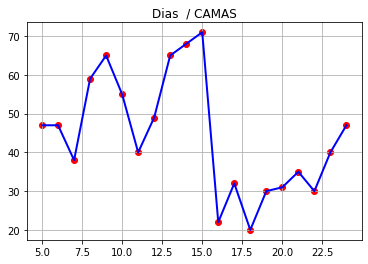

In [3]:

print('Camas Disponibles',camasTotal)
datos=sorted(camasTotal.items())
x, y =zip(*datos)
pp.plot(x,y,linewidth=2,color='b') 
pp.scatter(x,y,color='r')
pp.title("Dias  / CAMAS")
pp.grid(True)
pp.show() 


Personal Disponible {5: 47, 6: 47, 7: 38, 8: 59, 9: 65, 10: 55, 11: 40, 12: 49, 13: 65, 14: 68, 15: 71, 16: 22, 17: 32, 18: 20, 19: 30, 20: 31, 21: 35, 22: 30, 23: 40, 24: 47}


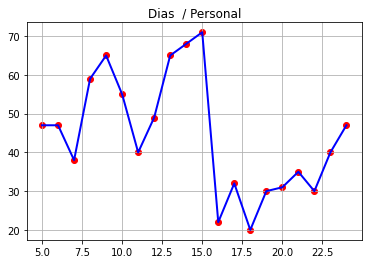

In [4]:

print('Personal Disponible',personalTotal)
datos=sorted(personalTotal.items())
x, y =zip(*datos)
pp.plot(x,y,linewidth=2,color='b') 
pp.scatter(x,y,color='r')
pp.title("Dias  / Personal")
pp.grid(True)
pp.show() 

Salas de Cuidados intensivos {5: 8, 22: 1, 23: 2}


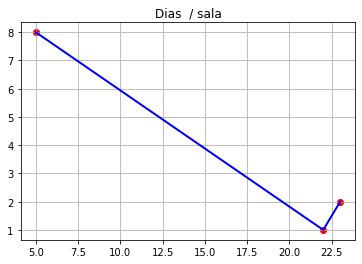

In [5]:

print('Salas de Cuidados intensivos',UCITotal)
datos=sorted(UCITotal.items())
x, y =zip(*datos)
pp.plot(x,y,linewidth=2,color='b') 
pp.scatter(x,y,color='r')
pp.title("Dias  / sala")
pp.grid(True)
pp.show() 

Respiradores Disponibles {13: 1, 17: 1, 19: 1, 22: 2}


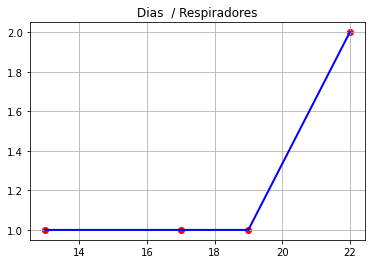

In [6]:

print('Respiradores Disponibles',respiradoresTotal)
datos=sorted(respiradoresTotal.items())
x, y =zip(*datos)
pp.plot(x,y,linewidth=2,color='b') 
pp.scatter(x,y,color='r')
pp.title("Dias  / Respiradores")
pp.grid(True)
pp.show() 

Ninios TOTAL {0: 40, 1: 3, 2: 7, 3: 4, 4: 5, 5: 3, 6: 2, 7: 2, 8: 5, 9: 6, 10: 5, 11: 5, 12: 3, 13: 1, 14: 6, 15: 5, 16: 4, 17: 9, 18: 4, 19: 3, 20: 5, 21: 2, 22: 2, 23: 2, 24: 4}


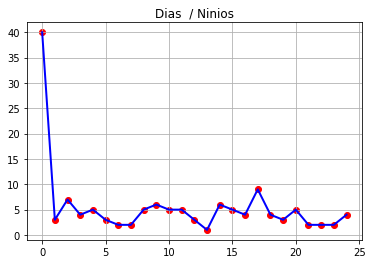

In [8]:

print('Ninios TOTAL',ninios)
datos=sorted(ninios.items())
x, y =zip(*datos)
pp.plot(x,y,linewidth=2,color='b') 
pp.scatter(x,y,color='r')
pp.title("Dias  / Ninios")
pp.grid(True)
pp.show() 


Mayores {0: 102, 1: 4, 2: 6, 3: 6, 4: 6, 5: 9, 6: 10, 7: 11, 8: 7, 9: 12, 10: 8, 11: 7, 12: 7, 13: 4, 14: 6, 15: 6, 16: 6, 17: 9, 18: 9, 19: 7, 20: 10, 21: 5, 22: 6, 23: 9, 24: 11}


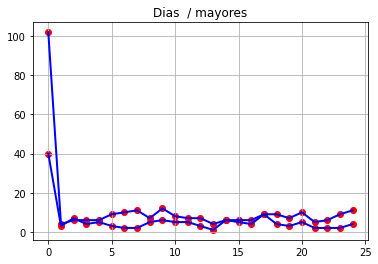

In [9]:

print('Mayores',adultos)
datos=sorted(adultos.items())
xA, yA =zip(*datos)
pp.plot(x,y,linewidth=2,color='b') 
pp.plot(xA,yA,linewidth=2,color='b') 
pp.scatter(x,y,color='r')
pp.scatter(xA,yA,color='r')

pp.title("Dias  / mayores")
pp.grid(True)
pp.show() 


Totalidad {5: 47, 6: 47, 7: 38, 8: 59, 9: 65, 10: 55, 11: 40, 12: 49, 13: 65, 14: 68, 15: 71, 16: 22, 17: 32, 18: 20, 19: 30, 20: 31, 21: 35, 22: 30, 23: 40, 24: 47}


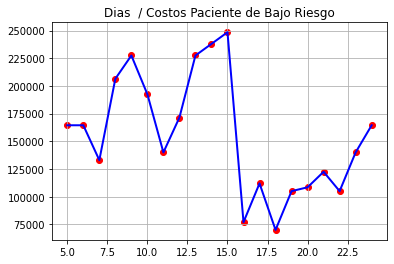

Gastos ciudados intensivos {13: 1, 17: 1, 19: 1, 22: 2}


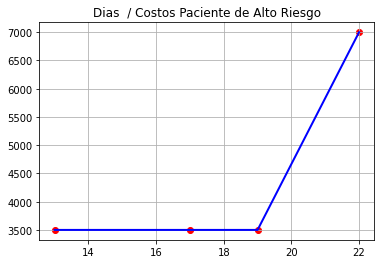

In [12]:


print('Totalidad',atendidos)
datos=sorted(atendidos.items())
x, y =zip(*datos)
Y=[]
for i in range(len(y)):
    costoB=(int(y[i]*COSTOB))
    Y.append(costoB)
    
pp.plot(x,Y,linewidth=2,color='b') 
pp.scatter(x,Y,color='r')
pp.title("Dias  / Costos Paciente de Bajo Riesgo")
pp.grid(True)
pp.show() 

print('Gastos ciudados intensivos',respiradoresTotal)
datos=sorted(respiradoresTotal.items())
x, y =zip(*datos)

Y=[]
for i in range(len(y)):
    costoA=(int(y[i]*COSTOB))
    Y.append(costoA)
pp.plot(x,Y,linewidth=2,color='b') 
pp.scatter(x,Y,color='r')
pp.title("Dias  / Costos Paciente de Alto Riesgo")
pp.grid(True)
pp.show() 

Bajo Riesgo {0: 212, 1: 17, 2: 16, 3: 15, 4: 12, 5: 16, 6: 16, 7: 11, 8: 15, 9: 13, 10: 13, 11: 17, 12: 16, 13: 18, 14: 14, 15: 18, 16: 15, 17: 13, 18: 19, 19: 18, 20: 11, 21: 11, 22: 17, 23: 11, 24: 18}


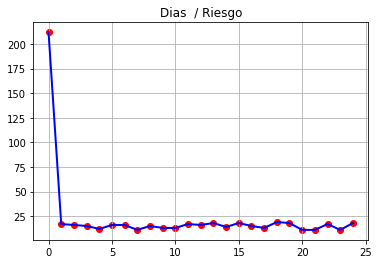

In [13]:

print('Bajo Riesgo',riesgo)
datos=sorted(riesgo.items())
x, y =zip(*datos)
pp.plot(x,y,linewidth=2,color='b') 
pp.scatter(x,y,color='r')
pp.title("Dias  / Riesgo")
pp.grid(True)
pp.show() 


## Conclusiones

Dado los modelos de simulación que se plantean se pueden llegar a obtener un visón de los eventos que se suscitan, con el fin de llegar a tener resultados esperados a partir de los datos que se pueden llegar obtener.

En definitiva, puedo decir que en base a los implementos que tenga un centro de atención medica que atienda los casos del virus Covid se puede establecer una estadística de personas que podrían llegar a fallecer por la falta de equipamiento.


## Recomendaciones

En base a los datos investigados, lo recomendables es que en la simulación se trate de obtener los datos más relevantes para de ese modo poder encontrar los caos de fallecimiento de manera oportuna con el fin de tener una idea clara de cómo iría en rumbo de la situación actual.



## Opiniones

Los eventos actuales pueden llegar a hacer bastante preocupantes además de que los centros de atención médicas que han tratado de combatir el virus, no están del todo adecuados con los implementos necesario, debido a eso las personas que ha llegado a el estado crítico de la situación lo mas probables sean las que fallecen ya que el tratamiento no sería el adecuado.
